# Análise de Afinidade Artística com Machine Learning e NLP

> Este projeto utiliza técnicas de aprendizado de máquina e processamento de linguagem natural (NLP) para analisar como os artistas se alinham com a sua época, com base nas letras de músicas e atributos musicais. O estudo envolve coleta de dados do Spotify, pré-processamento de texto, vetorização, análise de sentimento e cálculo de afinidade.


## Importação de Bibliotecas e Configuração

> Neste trecho, importamos as bibliotecas necessárias e configuramos variáveis de ambiente com as credenciais da API do Spotify e Kaggle.

> Esse trecho é desnecessário caso já possua o dataset *clean_music_dataset.csv* em seu diretório. 

(A única chave de API que precisaria ser iniciada é a Gemini API Key)

> Em seguida baixamos o dataset de músicas com atributos e letras utilizando o KaggleHub.

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
SPOTIFY_SECRET = os.getenv('SPOTIFY_SECRET')
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')

In [80]:
import kagglehub
import pandas as pd
from pathlib import Path

path = kagglehub.dataset_download("bwandowando/spotify-songs-with-attributes-and-lyrics")

path = Path(path)
df = pd.read_csv(path / 'songs_with_attributes_and_lyrics.csv')
df.head()

,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou..."
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n..."
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n"
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173.0,Continuamente se extraña la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827.0,Continuamente se extraña la gente si no puede ...


> Nesse trechco utilizo a API do Spotify para preencher os campos de ano e popularidade das músicas utilizando o id do dataset.

> Para tratar o dataset completo, basta redefinir a varíavel *LIMIT* para um número <= 0

> O código opera com salvamento a cada 500 linhas adicionadas, uma vez que ao terminar a cota da API essa só pode ser reutilizada após 24 horas.

In [ ]:
import pandas as pd
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm

ARQUIVO_SAIDA = "music_dataset_new.csv"
LIMIT = 100000 
BATCH_SIZE = 100

client_credentials_manager = SpotifyClientCredentials(
    client_id=SPOTIFY_CLIENT_ID,
    client_secret=SPOTIFY_SECRET
)
sp = Spotify(client_credentials_manager=client_credentials_manager)

if LIMIT <= 0:
    df = df.copy()
else:
    df = df.head(LIMIT).copy() 

try:
    df_saida = pd.read_csv(ARQUIVO_SAIDA)
except FileNotFoundError:
    df_saida = df.copy()
    df_saida['year'] = None

if 'popularity' not in df_saida.columns:
    df_saida['popularity'] = None

ids_faltantes = df.loc[~df['id'].isin(df_saida['id'])].copy()

if not ids_faltantes.empty:
    ids_faltantes['year'] = None
    df_saida = pd.concat([df_saida, ids_faltantes], ignore_index=True)

def get_years_and_popularity_batch(track_ids):
    years = []
    popularity = []
    try:
        results = sp.tracks(track_ids)
        for track in results['tracks']:
            if track:
                if 'release_date' in track['album']:
                    year = int(track['album']['release_date'][:4])
                else:
                    year = None
                years.append(year)

                popularity.append(track.get('popularity', None))
            else:
                years.append(None)
                popularity.append(None)
    except Exception as e:
        print(f"Erro no batch: {e}")
        years = [None] * len(track_ids)
        popularity = [None] * len(track_ids)
    return years, popularity


for i in tqdm(range(0, len(df_saida), BATCH_SIZE)):
    batch = df_saida.iloc[i:i+BATCH_SIZE]
    mask_na = batch['year'].isna()
    ids_para_buscar = batch[mask_na]['id'].tolist()

    if ids_para_buscar:
        anos, popularidade = get_years_and_popularity_batch(ids_para_buscar)
        df_saida.loc[batch[mask_na].index, 'year'] = anos
        df_saida.loc[batch[mask_na].index, 'popularity'] = popularidade

    if i % 500 == 0:
        df_saida.to_csv(ARQUIVO_SAIDA, index=False)

df_saida.to_csv(ARQUIVO_SAIDA, index=False)


100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s]


> São filtradas apenas as colunas necessárias do dataset.

> É criada a coluna *decade*, utilizada para simplificar a diferenciação das músicas por década.

> As letras das músicas são tratadas para serem mais facilmente processadas.

> Linhas com *decade* = 0 são removidas

In [ ]:
df = pd.read_csv(ARQUIVO_SAIDA)

df = df[['year', 'lyrics', 'name', 'artists', 'popularity']]
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['decade'] = (df['year'] // 10 * 10).astype(int)
df['lyrics'] = df['lyrics'].fillna('')
df['lyrics'] = df['lyrics'].str.lower()
df['lyrics'] = df['lyrics'].str.replace(r'\n', ' ', regex=True) 
df = df[df['decade'] != 0]

df.to_csv("clean_music_dataset.csv", index=False)
df.head()

,year,lyrics,name,artists,popularity,decade
0,2016,"he said he came from jamaica, he owned a coup...",!,['HELLYEAH'],0.0,2010
1,2019,"fucked a bitch, now she running with my kids ...",!!,Yxngxr1,32.0,2010
2,2019,"oh, my god, i'm going crazy",!!! - Interlude,['Glowie'],0.0,2010
3,2000,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],7.0,2000
4,1986,continuamente se extraña la gente si no puede ...,!!De Repente!!,['Rosendo'],16.0,1980


## Treinamento do Modelo

> Se já possuir o dataset *clean_music_dataset.csv* no diretório pode iniciar a execução por aqui.

> É realizado um TfidfVectorizer e uma regressão logística para gerar e testar um modelo de predição de décadas através da letra.

In [ ]:
import pandas as pd

df = pd.read_csv("clean_music_dataset.csv")

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df['lyrics'])
y = df['decade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        1900       0.00      0.00      0.00         6
        1920       0.00      0.00      0.00        13
        1930       0.00      0.00      0.00        13
        1940       0.00      0.00      0.00        16
        1950       0.50      0.03      0.06       133
        1960       0.33      0.02      0.04       298
        1970       0.17      0.01      0.02       446
        1980       0.75      0.01      0.01       580
        1990       0.18      0.01      0.01      1332
        2000       0.39      0.38      0.38      5555
        2010       0.49      0.76      0.60      8798
        2020       0.53      0.14      0.22      2803

    accuracy                           0.46     19993
   macro avg       0.28      0.11      0.11     19993
weighted avg       0.44      0.46      0.40     19993



c:\Users\cailu\Documents\Work\NLP\nlp_course\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cailu\Documents\Work\NLP\nlp_course\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cailu\Documents\Work\NLP\nlp_course\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

> Os resultados de predição do modelo não são o foco do trabalho, portanto não precisaremos de maiores avaliações a seu respeito.

> Nesse trecho são extraídos os pesos das palavras que mais afetam o modelo.

> Para tal o modelo é retreinado utilizando o conjunto completo de dados.

In [97]:
import numpy as np

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_

decades = clf.classes_
top_words = {}

for i, decade in enumerate(decades):
    top_indices = np.argsort(coefs[i])[-500:]
    top_words[decade] = feature_names[top_indices]

decade_word_weights = {
    decade: dict(zip(feature_names, coefs[i]))
    for i, decade in enumerate(decades)
}

for decade, words in top_words.items():
    print(f"{decade}s: {', '.join(words[:10])}")


1900s: nice, party, moment, box, near, standing, sen, follow, dumb, holla
1910s: asap, voit, amamos, blunted, autour, ਆਹ, berry, escapa, venceu, paulo
1920s: past, winter, dil, pray, torn, esa, church, sat, golden, turn
1930s: libertad, twilight, cu, entero, wonderin, misery, penas, bridge, named, eventually
1940s: donne, hacerte, teeth, grant, moments, street, raining, rich, olvidar, answered
1950s: hand, llegue, tip, wore, forgive, morir, allá, feathers, silver, boca
1960s: señor, hopes, stopped, doo, shores, fun, bell, disappear, anita, journey
1970s: touch, deals, understand, buddy, blown, dreamer, sailor, intention, air, tap
1980s: wearing, silencio, en, number, ho, pam, evil, attack, knowin, stab
1990s: receive, belfast, mack, dead, copas, vacant, anybody, lachen, na, हम
2000s: tragedy, braços, role, tits, saves, killers, crimson, mnie, aur, doesn
2010s: adora, imma, realm, saying, 있는, stage, wraith, 지금, soar, captured
2020s: auntie, miran, chasin, bad, destruction, fare, kim, ca

## Pesquisa de Sentimento com LLM

> Nesse trecho do trabalho é realizada uma pergunta para a LLM Gemini, pedindo-a para classificar o sentimento transmitido pelas palavras mais comuns de cada década.

> Para tal são utilizadas as 100 palavras mais comuns de cada década.

In [98]:
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [99]:
def analisar_sentimento_decada(palavras):
    prompt = f"""
    Você é um analista de sentimentos em letras de músicas.

    Dada a seguinte lista de palavras mais frequentes e relevantes para músicas de uma decada específica, identifique qual sentimento ou clima emocional essas palavras em conjunto refletem sobre o espírito daquela época.

    Palavras: {', '.join(palavras)}

    Analise o sentimento predominante transmitido por essas palavras no contexto de letras musicais da época. 
    Responda com apenas 3 palavras que melhor descrevem o sentimento e contexto sociocultural que pode ser atrelado a determinada década.
    """
    
    response = model.generate_content(prompt)
    return response.text.strip()


In [100]:
analises_sentimento = {}

for decada, palavras in top_words.items():
    sentimento = analisar_sentimento_decada(palavras)
    analises_sentimento[decada] = sentimento

> Nota-se um sentimento visto como nostalgia até os anos 70, possívelmente pela interpretação da LLM de palavras que remetem a época.

> É interessante reparar como o sentimento passa de nostalgia romântica até os anos 50, para um pequeno trecho envolvendo liberdade dos anos 60 e 70 e calha em um sentimento de rebeldia que atravessa até os anos 2010.

> Notável também que termos novos como ansiedade e autodestruição aparecem pela primeira vez nos anos 2010 e 2020.

In [101]:
print("\nAnálise de Sentimento por Década:")
for decada, sentimento in analises_sentimento.items():
    print(f"{decada}s: {sentimento}")


Análise de Sentimento por Década:
1900s: Rebeldia,  Esperança,  Riqueza.
1910s: Festa, ostentação, globalização.
1920s: Nostalgia melancólica romântica
1930s: Nostalgia,  rebeldia,  romance.
1940s: Nostalgia romântica nostálgica.
1950s: Nostalgia melancólica romântica
1960s: Otimismo,  Nostalgia, Liberdade.
1970s: Nostalgia, liberdade, rebeldia.
1980s: Rebeldia,  energia,  desejo.
1990s: Rebelião,  desejo,  desilusão.
2000s: Rebelião,  escuridão,  excessos.
2010s: Autodestruição,  Excessos,  Rebeldia.
2020s: Ansiedade,  autodestruição, efemeridade.


## Geração do Dataset de Afinidade dos Artistas

> Nesse trecho são realizados novos tratamentos para gerar o arquivo *artists_afinity.csv*.

> Caso já possua o mesmo em seu diretório esse trecho não é necessário

> Primeiramente é necessário separar artistas que dividem uma mesma faixa, agrupando as músicas com o respectivo artista.

In [167]:
from sklearn.feature_extraction.text import CountVectorizer
import ast

def parse_artists(entry):
    if isinstance(entry, list):
        return entry
    if isinstance(entry, str):
        try:
            val = ast.literal_eval(entry)
            if isinstance(val, list):
                return val
            else:
                return [val]
        except:
            return [entry]
    return [str(entry)]

df['artists'] = df['artists'].apply(parse_artists)
df_exploded = df.explode('artists').rename(columns={'artists': 'artist'})

artista_letras = df_exploded.groupby("artist")["lyrics"].apply(lambda x: " ".join(str(t) for t in x))


> Além de extrair a frequência com que cada palavra aparece para o artista, é realizado o cálculo com o peso extraído do modelo de regressão logística.

> Tal processo permite gerar um score de afinidade com época para o artista.

> Em sequência esses dados são salvos em *artists_afinity.csv* para evitar repetições na execução do código.

In [168]:
artista_streams_max = df_exploded.groupby("artist")["popularity"].max()

def get_frequencias(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {}
    vectorizer = CountVectorizer(stop_words='english')
    try:
        X = vectorizer.fit_transform([text])
        total = X.sum()
        return dict(zip(vectorizer.get_feature_names_out(), X.toarray()[0] / total))
    except ValueError:
        return {}

artista_frequencias = artista_letras.apply(get_frequencias)

def calcular_afinidade_combinada(freq_artista, pesos_decada):
    score = 0
    for palavra, freq in freq_artista.items():
        peso = pesos_decada.get(palavra, 0)
        score += freq * peso
    return score

afinidade_resultados = []

for artista, freq in artista_frequencias.items():
    artista_musicas = df_exploded[df_exploded["artist"] == artista]
    decadas = artista_musicas["decade"].unique()
    
    popularidade_label = artista_streams_max.get(artista, 0)

    for dec in decadas:
        if dec in decade_word_weights:
            score = calcular_afinidade_combinada(freq, decade_word_weights[dec])
            afinidade_resultados.append({
                "artista": artista,
                "decada": dec,
                "afinidade_com_epoca": score,
                "popularidade": popularidade_label
            })

df_afinidade = pd.DataFrame(afinidade_resultados)
df_afinidade.to_csv("artists_afinity.csv", index=False)


## Análise dos Resultados de Afinidade dos Artistas

> Enfim, através do último dataset, é possível identificar questões interessantes e explorar a relação dos artistas com suas décadas.

In [ ]:
df_afinidade = pd.read_csv("artists_afinity.csv")
df_afinidade = df_afinidade.sort_values(by="afinidade_com_epoca", ascending=False)
df_afinidade.head()

,artista,decada,afinidade_com_epoca,popularidade
21936,KOLIDESCOPES,2020,1.522729,0.0
33291,Primal Scream,2010,1.447803,9.0
19871,Jean-Michel Jarre,2010,1.447803,9.0
37265,Shelf Lives,2020,1.306334,26.0
32911,Pixel Terror,2020,1.272419,42.0


In [ ]:

def mostrar_afinidade_por_decada(df_afinidade, decada, popularity_treshold ,top_n=10):
    df_filtrado = df_afinidade[df_afinidade['decada'] == decada]
    df_filtrado = df_filtrado[df_filtrado['popularidade'] >= popularity_treshold]

    if df_filtrado.empty:
        print(f"Nenhum dado encontrado para a década {decada}.")
        return

    print(f"\nTop {top_n} artistas mais alinhados com os anos {decada}:")
    top = df_filtrado.sort_values(by='afinidade_com_epoca', ascending=False).head(top_n)
    for i, row in top.iterrows():
        print(f"{row['artista']}: {row['afinidade_com_epoca']:.2f}")

    print(f"\nTop {top_n} artistas menos alinhados com os anos {decada}:")
    bottom = df_filtrado.sort_values(by='afinidade_com_epoca', ascending=True).head(top_n)
    for i, row in bottom.iterrows():
        print(f"{row['artista']}: {row['afinidade_com_epoca']:.2f}")


> A seguinte função permite a visualização dos 10 artistas mais condizentes com sua época e dos 10 artistas menos condizentes com sua época, por um treshold de popularidade, que permite a visualização apenas dos artistas mais famosos.

In [169]:
decada = 2000
popularidade = 85

mostrar_afinidade_por_decada(df_afinidade, decada, popularidade)


Top 10 artistas mais alinhados com os anos 2000:
System Of A Down: 0.12
Green Day: 0.07
Arctic Monkeys: 0.04
Coldplay: 0.01
TOTO: 0.00
John Legend: -0.04
Michael Jackson: -0.05
AC/DC: -0.05
Britney Spears: -0.06
Justin Bieber: -0.07

Top 10 artistas menos alinhados com os anos 2000:
Tammi Terrell: -0.16
Lady Gaga: -0.13
Marvin Gaye: -0.12
Justin Bieber: -0.07
Britney Spears: -0.06
AC/DC: -0.05
Michael Jackson: -0.05
John Legend: -0.04
TOTO: 0.00
Coldplay: 0.01


In [170]:
import matplotlib.pyplot as plt

def plot_afinidade_por_decada(df_afinidade, treshold):
    decadas = df_afinidade['decada'].unique()
    afinidade_diff = []
    for decada in sorted(decadas):
        df_decada = df_afinidade[df_afinidade['decada'] == decada]
        max_popularity = df_decada['popularidade'].max()
        df_decada = df_decada[df_decada['popularidade'] >= max_popularity * treshold]
        if not df_decada.empty:
            afinidade_diff.append(df_decada['afinidade_com_epoca'].mean())
        else:
            afinidade_diff.append(0)

    plt.figure(figsize=(12, 6))
    plt.bar(sorted(decadas), afinidade_diff, color='skyblue')
    plt.xlabel('Década')
    plt.ylabel('Diferença de Afinidade')
    plt.title('Diferença de Afinidade com a Década por Popularidade')
    plt.xticks(sorted(decadas), rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()


> Os gráficos plotado permite a visualização da média de afinidade que os artistas possuíam a cada época, filtrando primeiramente pelos artistas mais famosos de cada época e em seguida pela maioria dos artistas de cada época.

> Através dos gráficos, é interessante notar como atualmente os artistas mais populares estão mais alinhados do que nunca com sua respectiva década, enquanto ao analisar os artistas em geral percebesse que houveram épocas com maior alinhamento que na década atual.

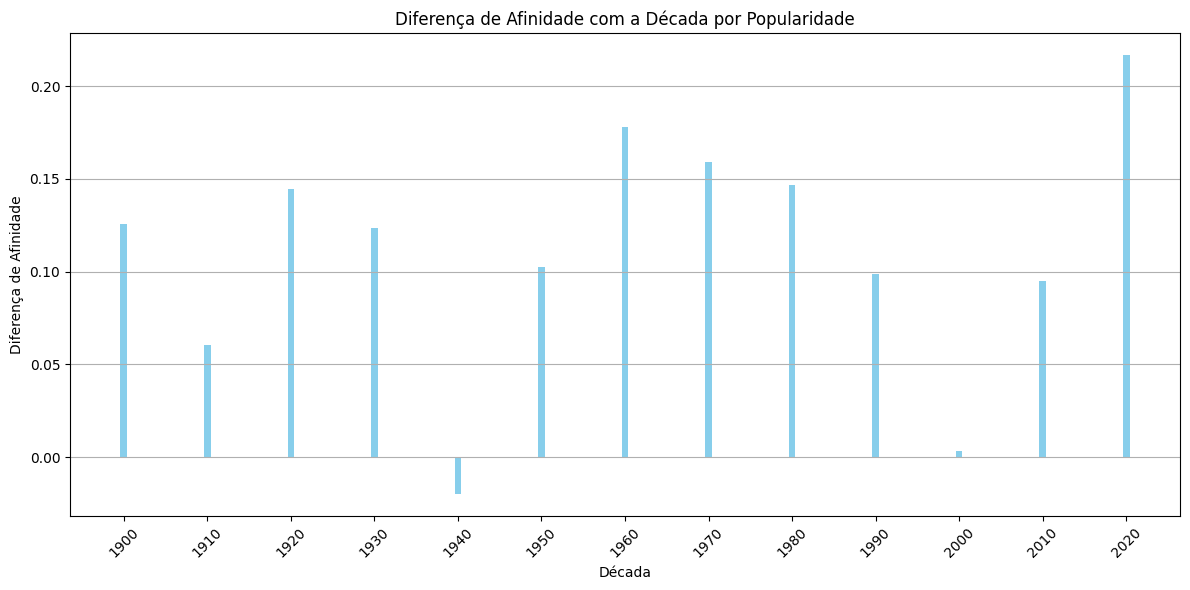

In [171]:
plot_afinidade_por_decada(df_afinidade, 0.9)

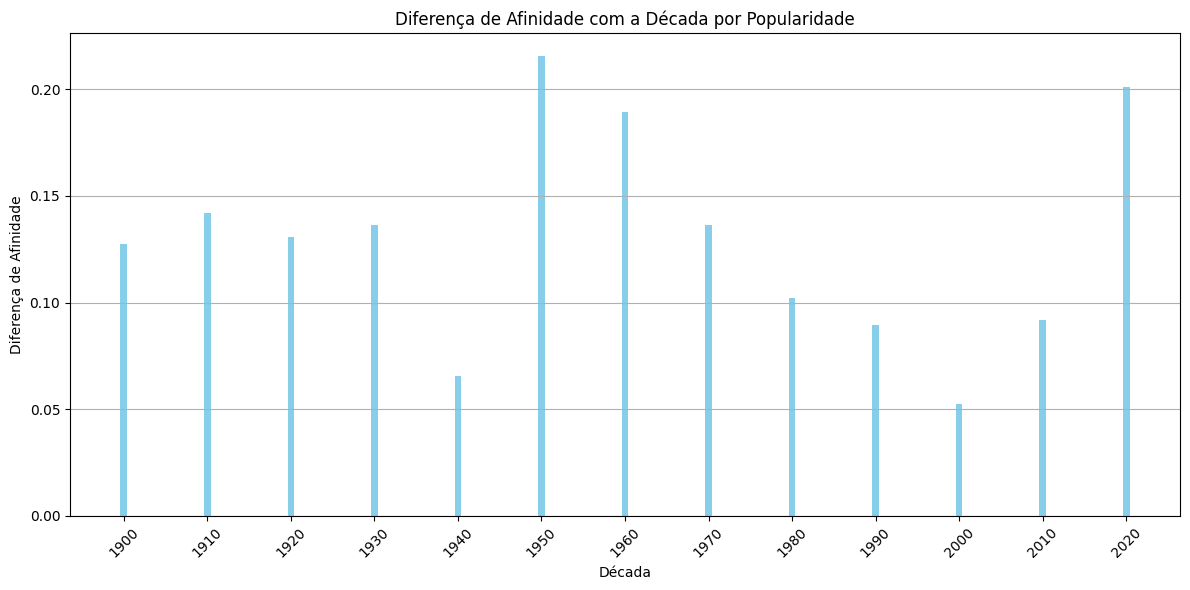

In [166]:
plot_afinidade_por_decada(df_afinidade, 0.1)